# Tracklist Generator: Embeddings
This notebook contains the code for the generation of artist, user, and song embeddings from the 1001Tracklists dataset. It implements an expanded version of Sun et al.'s [Multi-Graph Convolution Collaborative Filtering (2020)](https://arxiv.org/abs/2001.00267); we will refer to our version of this model as Tracklist Multi-Graph Convolution Collaborative Filtering, or **TL-MGCCF**. 

As explained in the [Data Preparation notebook](1.%20Data_Preparation.ipynb), there are three key types of object in this model. We are trying to recommend **songs**, and each song has associated **artists** who produced/remixed it. Finally, there are **users**, which were generated using the DJs who curated the tracklists in the data. The goal of this notebook is to train a model which will be able to recommend songs to users, using the artist information to enrich these recommendations.

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Concatenate, LSTM, Activation, Embedding, Add, Dot, Multiply, Dropout, BatchNormalization,Flatten
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

from scipy.sparse import csr_matrix
import scipy
import math
from sklearn.metrics.pairwise import cosine_similarity
import random
from typing import Tuple
import pickle
import matplotlib.pyplot as plt
import bottleneck as bn
from tabulate import tabulate
import time

# Data imports
As prepared in the [Data Preparation notebook](1.%20Data_Preparation.ipynb), the 1001Tracklists co-occurrence data is stored in a series of pickled scipy sparse matrices, which we import and convert to SparseTensors. These include a song-song co-occurrence matrix, a song-artist co-occurrence matrix, and an artist-artist co-occurrence matrix, along with a song-artist map which indicates for each song the artist(s) that produced it.

In [2]:
with open('Sparse Matrices v2/song_song_sparse.pkl','rb') as f:
    song_song_sparse = pickle.load(f)

with open('Sparse Matrices v2/song_artist_sparse.pkl','rb') as f:
    song_artist_sparse = pickle.load(f)

with open('Sparse Matrices v2/artist_artist_sparse.pkl','rb') as f:
    artist_artist_sparse = pickle.load(f)
    
with open('Sparse Matrices v2/song_artist_map_sparse.pkl','rb') as f:
    song_artist_map_sparse = pickle.load(f)
    

We also import pickled sparse matrices for user-song co-occurrence and user-artist co-occurrence and convert them to dense arrays. These each have two versions, one which has been standardised along the user dimension and one which has been standardised along the song/artist dimension.

In [3]:
with open('Sparse Matrices v2/user_song_sparse_scaled_user.pkl','rb') as f:
    user_song_scaled_user = np.array(pickle.load(f).todense())
    
with open('Sparse Matrices v2/user_song_sparse_scaled_song.pkl','rb') as f:
    user_song_scaled_song = np.array(pickle.load(f).todense())

with open('Sparse Matrices v2/user_artist_sparse_scaled_user.pkl','rb') as f:
    user_artist_scaled_user = np.array(pickle.load(f).todense())

with open('Sparse Matrices v2/user_artist_sparse_scaled_artist.pkl','rb') as f:
    user_artist_scaled_artist = np.array(pickle.load(f).todense())

We import the original dictionary which contains the indices of the positive examples for each user, and create a new dictionary with the scores removed.

In [4]:
with open('user_song_dict_2021_training.pkl','rb') as f:
    user_selection_full=pickle.load(f)

user_selection_inds = {}
for user in user_selection_full:
    user_selection_inds[user] = user_selection_full[user]['Songs']

We import the pickled numpy array which contains the user adjacency matrix (created by taking the cosine similarity of the user-song click matrix) and convert it to a scipy sparse matrix.

In [5]:
with open('Sparse Matrices v2/user_adj.pkl','rb') as f:
    user_adj = pickle.load(f)
    
user_adj_sparse = csr_matrix(user_adj)

Finally, we import the pickled lists which contain the names of songs, artists, and users.

In [6]:
with open('Sparse Matrices v2/song_lst.pkl','rb') as f:
    song_lst = pickle.load(f)

with open('Sparse Matrices v2/artist_lst.pkl','rb') as f:
    artist_lst = pickle.load(f)

with open('Sparse Matrices v2/user_lst.pkl','rb') as f:
    user_lst = pickle.load(f)


# Defining the model
In this section, we build the Tensorflow model implementing TL-MGCCF the expanded version of Sun et al.'s Multi-Graph Convolution Collaborative Filtering (Multi-GCCF). We begin by importing some helper functions, one for converting a scipy sparse matrix to a sparse tensor, one for a more memory efficient way to take a categorical sample from a tensor, and one for normalizing the adjacency matrix of a graph (taken from the [implementation](https://github.com/google-research/google-research/tree/master/graph_embedding/dmon) of [Graph Clustering with Graph Neural Networks](https://arxiv.org/abs/2006.16904)).

In [7]:
from tl_utils import convert_scipy_sparse_to_sparse_tensor,normalize_graph,categorical

## Preliminaries: Multi-GCCF
At its core, our TL-MGCCF embedding model will implement an expanded version of Sun et al.'s Multi-GCCF. We will therefore outline the architecture and training regime of this model first before moving on to our model.

### Model Architecture
In the original Multi-GCCF paper, recommendation is presented as a problem on a bipartite graph with user nodes and item nodes, with user-item edges representing interaction. The goal of the Multi-GCCF model is to learn user and item embeddings which capture these interactions using model-based collaborative filtering. The output of Multi-GCCF is therefore a set of embedding vectors for items and for users. These embeddings are calculated as the sum of three separate vectors. The full model architecture is shown in Sun et al.'s Figure 1, reproduced below.

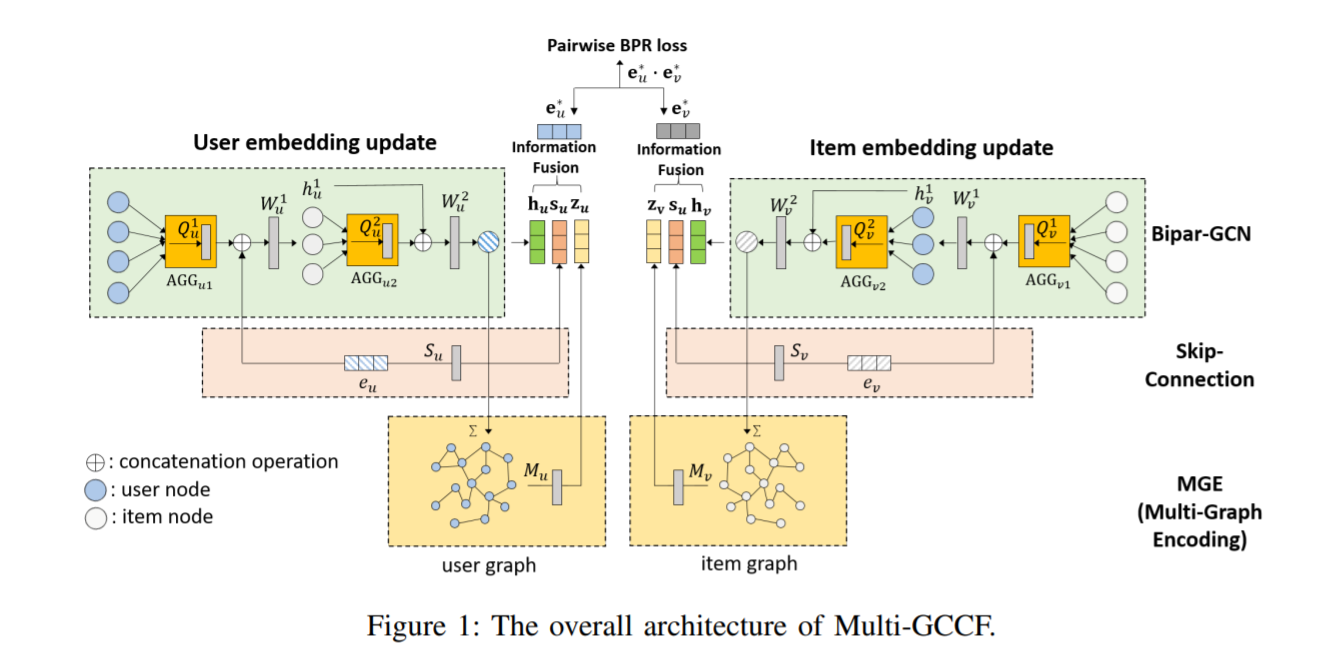

#### Bipar-GCN
The Bipar-GCN vectors ($h_u$ and $h_v$ in the diagram) are generated by neighbourhood sampling in the user-item bipartite graph. Let $U$ be the set of users and $V$ be the set of items. At each layer $k$ in the Bipar-GCN model, a fixed-size neighbourhood sample of size $n_k$ is taken, to form neighbourhoods $\mathcal{N}_k(u) \subset V$ and $\mathcal{N}_k(v) \subset U$ for each $u \in U, v \in V$. Initial embeddings $e_u$ and $e_v$, learned for each $u$ and $v$, form the input of the first layer, so $h_u^0 = e_u$ and $h_v^0 = e_v$. The layer-$k$ embedding for a user $u$ or item $v$ is then calculated as follows: 

$$h_u^k = \sigma\left(W_u^k \centerdot \left[h_u^{k-1} ; h_{\mathcal{N}_k(u)}^{k-1}\right]\right),\; \; \;  h_v^k = \sigma\left(W_v^k \centerdot \left[h_v^{k-1} ; h_{\mathcal{N}_k(v)}^{k-1}\right]\right)$$

where $\sigma(\centerdot)$ is the $\textrm{tanh}$ activation function, $[ ; ]$ represents concatenation, and $W_u^k$ and $W_v^k$ are learned weight matrices. $h_{\mathcal{N}_k(u)}^{k-1}$ and $h_{\mathcal{N}_k(v)}^{k-1}$ are the learned neighbourhood embeddings, which are created by aggregating the embeddings of each member of the user/item's neighbourhood:

$$h_{\mathcal{N}_k(u)}^{k-1} = \sigma\left(\textrm{MEAN}\left(\left\{h_v^{k-1} \centerdot Q_u^k, v \in \mathcal{N}_k(u)\right\}\right)\right), \; \; \; h_{\mathcal{N}_k(v)}^{k-1} = \sigma\left(\textrm{MEAN}\left(\left\{h_u^{k-1} \centerdot Q_v^k, u \in \mathcal{N}_k(v)\right\}\right)\right)$$

where $Q_u^k$ and $Q_v^k$ are again learned weight matrices. The $h_u^K$ and $h_v^K$ output vectors of the final layer $K$ are the output vectors $h_u$ and $h_v$ of Bipar-GCN. In the diagram above, and in our implementation of Multi-GCCF, the number of layers is 2, so $K = 2$.

#### Multi-Graph Encoding
The output of the Bipar-GCN is further enriched by including user-user and item-item interaction information to transform the learned embeddings by graph convolution. If these user-user and item-item graphs are not already available, Sun et. al suggest that they can be generated by taking the cosine similarity of the columns/rows of the user-item interaction matrix. The outputs $z_u$ and $z_v$ of the Multi-Graph Encoding are calculated as follows:

$$z_u = \sigma\left(G_U \centerdot \left(e_U \centerdot M_u\right)\right), \; \; \; z_v = \sigma\left(G_V \centerdot \left(e_V \centerdot M_v\right)\right)$$

where $G_U$ and $G_V$ are the normalized adjacency matrices of the user-user and item-item interaction graphs, $e_U$ and $e_V$ are the initial user/item embeddings, and $M_u$ and $M_v$ are weight matrices. 

#### Skip-Connection
The final component of the Multi-GCCF output is a skip-connection from the original embeddings, so that this information is not lost through the graph transformations. The embeddings are passed through a single fully-connected layer to produce vectors $c_u$ and $c_v$ (note that in the diagram above, these are referred to as $s_u$ and $s_v$; we use $c_u$ and $c_v$ to avoid confusion, as we will shortly be using $s$ as a subscript). 

#### Information fusion 
The outputs of each of the three steps above are now fused together to form a single vector for each user/item. Sun et. al explore several methods for this fusion; we will use the element-wise sum method, so that $$e_u^* = h_u + z_u + c_u, \; \; \; e_v^* = h_v + z_v + c_v$$

### Model Training
Let $\mathcal{R}^+$ be the set of of observed positive user-item interaction pairs. Then, per Sun et. al's paper, Multi-GCCF is trained using Bayesian Personalized Recommendation (BPR) loss on triplets $(u, i, j)$, such that $(u,i) \in  \mathcal{R}^+$ and $(u,j) \notin  \mathcal{R}^+$. The BPR objective function is calculated as follows:

$$\mathcal{L}(u,i,j) = -\log\left(\textrm{sigmoid}\left(e_u^* \centerdot e_i^* - e_u^* \centerdot e_j^*\right)\right) + \lambda ||\Theta||^2_2 + \beta\left(||e_u^*||^2_2 + ||e_i^*||^2_2 + ||e_j^*||^2_2\right)$$

where $\Theta$ are the model parameters, $\lambda$ and $\beta$ are regularization coefficients, and $e_u^*$, $e_i^*$, $e_j^*$ are the outputs of Multi-GCCF for user $u$ and items $i$ and $j$.

## TL-MGCCF
We will now outline the architecture of the TL-MGCCF model, before implementing it as a Keras layer class in Tensorflow. 
### Model Overview
#### Expanding Multi-GCCF
TL-MGCCF expands on the traditional recommender system scenario that Multi-GCCF is designed to solve. We want to be able to recommend items (in this case, songs) to users. But we also have a third type of entity, artists, which have a very specific relationship with the songs we are trying to recommend; we can greatly improve the recommendation system by incorporating this artist information. 

We do this by building two Multi-GCCF models, one which processes user-song interactions ($\textrm{MGCCF}_s$) and the other user-artist interactions ($\textrm{MGCCF}_a$), with the song-song and artist-artist co-occurrence matrices being used as the adjacency matrices for the item graphs. The user graph, as shown in the [Data Preparation notebook](1.%20Data_Preparation.ipynb), is created following Sun et. al's suggestion by taking cosine similarity along the rows of the user-song click matrix. $\textrm{MGCCF}_s$ outputs user embeddings $e_u^{s*}$ and song embeddings $e_s^*$, while $\textrm{MGCCF}_a$ outputs user embeddings $e_u^{a*}$ and artist embeddings $e_a^*$. We want to enrich the song embeddings $e_s^*$ with information about the artist(s) that produced them. We will do this by performing matrix multiplication between the song-artist map $M$ and the artist embeddings $e_a^*$. To produce final embeddings, we concatenate the result with the original song embeddings $e_s^*$, and also concatenate $e_u^{s*}$ and $e_u^{a*}$, to get resulting vectors $\hat{e}_u = [e_u^{s*} ; e_u^{a*}]$,  $\hat{e}_s = [e_s^{*} ; M \centerdot e_s^{*}]$. The objective function then becomes 

$$\hat{\mathcal{L}}(u,i,j) = -\log\left(\textrm{sigmoid}\left(\hat{e}_u \centerdot \hat{e}_i - \hat{e}_u \centerdot \hat{e}_j\right)\right) + \lambda ||\hat{\Theta}||^2_2 + \beta\left(||\hat{e}_u||^2_2 + ||\hat{e}_i||^2_2 + ||\hat{e}_j||^2_2\right)$$

#### Matrix factorisation
We also introduce a significant new objective to the training process, by forcing the learned song and artist embeddings to factorise the co-occurrence matrices in the style of [GloVe word embeddings](https://nlp.stanford.edu/pubs/glove.pdf). This greatly enriches the song and artist vector representations, as it incorporates co-occurrence information from across the entire dataset, rather than only focussing on the songs which were played by a relatively small number of users. 

We will therefore add three new terms to the overall objective function, corresponding to matrix factorisation losses for the song-song, artist-artist, and song-artist co-occurrence matrices. We generalise the GloVe approach for a pair of embedding matrices $E$, $F$ and log-scaled co-occurrence matrix $X$, to calculate the loss as follows: 

$$ \mathcal{J}(E,F,X) = \sum f(X) * (\textrm{ReLU}(E^{\top} F) - X)^2$$

where $*$ is element-wise multiplication, and $f(X)$ is a scaling function applied element-wise to $X$ designed to ensure that rare co-occurrences are not overweighted. Abusing notation, we define $f$ for each $x$ in $X$:

$$f(x) = \begin{cases} 
      x_{min} & \textrm{if } x = 0, \\
      1 & \textrm{otherwise}
   \end{cases}
$$

where $x_{min}$ is a parameter to be chosen. Since we have already removed low co-occurrence scores as part of our Data Preprocessing, we only choose a small minimum value $x_{min}$ (in our model, it will be 0.05) so that the model also learns which songs do not co-occur.

To take full advantage of the graph information we possess, we will perform this factorisation after the Multi-GCCF embeddings have been through the GCN, and also include the skip connection output. Using the notation from above, this means our embeddings are defined as $\bar{e}_s = z_s + c_s$ and $\bar{e}_a = z_a + c_a$.

Now let $\bar{e}_S$, $\bar{e}_A$ be the full song and artist embedding matrices from Multi-GCCF generated this way, and $X_{SS}$, $X_{AA}$, and $X_{SA}$ be the song-song, artist-artist, and song-artist co-occurrence matrices respectively. We will need to define our matrix factorisation objective function for a single mini-batch of triplets $(u,i,j)$ to fit in with the training regime for Multi-GCCF. Rather than running gradient descent on the products of the full embedding matrices at each mini-batch, we will only run on the songs and artists which are involved in the batch against the full embeddings. 

More specifically, suppose we have a mini-batch $\mathcal{B} = \left\{(u,i,j) : (u,i) \in  \mathcal{R}^+, (u,j) \notin  \mathcal{R}^+\right\}$. Let $S_\mathcal{B}$ be the set of songs involved in the batch, i.e. $S_\mathcal{B} = \left\{i : (u,i,j) \in \mathcal{B}\} \cup \{j : (u,i,j) \in \mathcal{B}\right\}$, and $A_\mathcal{B}$ be the artists associated with those songs (i.e. any artists which have a non-zero value in the relevant row of the song-artist map). The song-song factorisation loss term for a single mini-batch is then $\mathcal{J}(\bar{e}_{S_\mathcal{B}},\bar{e}_S,X_{S_\mathcal{B}S})$ where $\bar{e}_{S_\mathcal{B}}$ denotes the rows of the song embedding matrix $\bar{e}_S$ pertaining to $S_\mathcal{B}$ and $X_{S_\mathcal{B}S}$ the rows of $X_{SS}$ pertaining to $S_\mathcal{B}$. Similarly, the artist loss term is $\mathcal{J}(\bar{e}_{A_\mathcal{B}},\bar{e}_A,X_{A_\mathcal{B}A})$. For the song-artist loss, the term has two components, one each for songs and for artists: $\mathcal{J}(\bar{e}_{A_\mathcal{B}},\bar{e}_S,X_{SA_\mathcal{B}}) + \mathcal{J}(\bar{e}_{S_\mathcal{B}},\bar{e}_A,X_{S_\mathcal{B}A})$. Taken together, these terms constitute the matrix factorisation loss for a mini-batch. 

### Model Implementation
We will now implement the TL-MGCCF model as described above in a Keras layer class.

In [8]:
class TL_MGCCF(tf.keras.layers.Layer):
    """Implements a two-layer TL-MGCCF model, as described above.

    Attributes:
        n_samples: A length two list indicating how many neighbourhood samples to take 
            at each layer in the MGCCF models
        song_adjacency: Song-song co-occurrence matrix in SparseTensor format
        artist_adjacency: Artist-artist co-occurrence matrix in SparseTensor format
        song_artist_adjacency: Song-artist co-occurrence matrix in SparseTensor format

        song_adjacency_normalized: Normalized song-song co-occurrence matrix in 
            SparseTensor format 
        artist_adjacency_normalized: Normalized artist-artist co-occurrence matrix in 
            SparseTensor format
        user_adjacency: Normalized user-user co-occurrence matrix in SparseTensor format

        user_song_adjacency_scaled_user: User-song click matrix in SparseTensor format,
            scaled along the user axis
        user_song_adjacency_scaled_song: User-song click matrix in SparseTensor format,
            scaled along the song axis
        user_artist_adjacency_scaled_user: User-artist click matrix in SparseTensor format,
            scaled along the user axis
        user_artist_adjacency_scaled_artist: User-song click matrix in SparseTensor format,
            scaled along the artist axis

        song_artist_map: Map in SparseTensor format from songs to artists which produced
            them - shape (n_songs, n_artists)

        embedding_dim: Size of learned embedding vectors for songs, artists, and users
        layer_sizes: Length two list of output sizes for intermediate layers in MGCCF
        l2_reg_param: Regularization parameter for l2 regularization in MGCCF loss function
        dropout_rate: Dropout rate to be applied throughout model
    """
    def __init__(self,
               n_samples,
                 song_adjacency,
                 artist_adjacency,
                 song_artist_adjacency,
                 song_adjacency_normalized,
                 artist_adjacency_normalized,
                 user_adjacency_normalized,
                 user_song_adjacency_scaled_user,
                 user_song_adjacency_scaled_song,
                 user_artist_adjacency_scaled_user,
                 user_artist_adjacency_scaled_artist,
                 song_artist_map,
                 embedding_dim,
                 layer_sizes,
                 l2_reg_param = 1e-4,
                 dropout_rate = 0.3,
                ):
            """Initializes the layer with specified parameters."""
            super(TL_MGCCF, self).__init__()
            self.n_samples = n_samples
            
            self.song_adjacency = song_adjacency
            self.artist_adjacency = artist_adjacency
            self.song_artist_adjacency = song_artist_adjacency
            
            self.song_adjacency_normalized = song_adjacency_normalized
            self.user_adjacency_normalized = user_adjacency_normalized
            self.artist_adjacency_normalized = artist_adjacency_normalized
            
            self.user_song_adjacency_scaled_user = user_song_adjacency_scaled_user
            self.user_song_adjacency_scaled_song = user_song_adjacency_scaled_song
            self.user_artist_adjacency_scaled_user = user_artist_adjacency_scaled_artist
            self.user_artist_adjacency_scaled_artist = user_artist_adjacency_scaled_artist
            
            self.song_artist_map = song_artist_map

            self.embedding_dim = embedding_dim
            self.layer_sizes = layer_sizes
            self.l2_reg_param = l2_reg_param
            self.dropout_rate = dropout_rate
            
            self.num_users = self.user_adjacency_normalized.shape[0]
            self.num_songs = self.song_adjacency.shape[0]
            self.num_artists = self.artist_adjacency.shape[0]
    
    def build(self, input_shape):
        """ Here we initialise the various weights, embeddings, and biases used in the model, 
        including l2 regularization on the weight matrices as described in the MGCCF 
        loss function"""
        
        reg_param = self.l2_reg_param
        
        """First we initialise the variables for the song, user, and artist embeddings."""
        self.embeddings = {}
        self.embeddings['user'] = self.add_weight('user_embedding', 
                                            shape=(self.num_users, self.embedding_dim))
        self.embeddings['song'] = self.add_weight('song_embedding', 
                                            shape=(self.num_songs,self.embedding_dim))
        self.embeddings['artist'] = self.add_weight('artist_embedding', 
                                          shape=(self.num_artists,self.embedding_dim))

        self.kernels = {}
        self.biases = {}
        self.skip_weights = {}
        
        """We now initialise the weight matrices used in the two MGCCF models in the Bipar-GCN stage.
        For clarity on which weight matrix is used at which step, refer to the MGCCF architecture
        diagram above. We first build the weights for the song-focused model MGCCF_s, and then for
        the artist model MGCCF_a.
        """
        def build_mgccf_weights(obj_type):
            """Builds the weight matrices for an MGCCF model.

            Args:
            item_type: The type of item entity (song or artist), included
                as a label to format the variable names
            """
            self.kernels['W_u_1_%s'%obj_type] = self.add_weight('W_u_1_%s'%obj_type, 
                                                    shape=(self.layer_sizes[0], 2*self.embedding_dim),
                                                    regularizer=regularizers.l2(reg_param))
            self.kernels['W_u_2_%s'%obj_type] = self.add_weight('W_u_2_%s'%obj_type, 
                                                    shape=(self.layer_sizes[1], 2*self.layer_sizes[0]),
                                                    regularizer=regularizers.l2(reg_param))

            self.kernels['W_%s_1'%obj_type] = self.add_weight('W_%s_1'%obj_type, 
                                                    shape=(self.layer_sizes[0], 2*self.embedding_dim),
                                                    regularizer=regularizers.l2(reg_param))
            self.kernels['W_%s_2'%obj_type] = self.add_weight('W_%s_2'%obj_type, 
                                                    shape=(self.layer_sizes[1], 2*self.layer_sizes[0]),
                                                    regularizer=regularizers.l2(reg_param))

            self.kernels['Q_u_1_%s'%obj_type] = self.add_weight('Q_u_1_%s'%obj_type,
                                                    shape=(self.embedding_dim, self.embedding_dim),
                                                    regularizer=regularizers.l2(reg_param))
            self.kernels['Q_u_2_%s'%obj_type] = self.add_weight('Q_u_2_%s'%obj_type, 
                                                    shape=(self.layer_sizes[0], self.layer_sizes[0]),
                                                    regularizer=regularizers.l2(reg_param))

            self.kernels['Q_%s_1'%obj_type] = self.add_weight('Q_%s_1'%obj_type, 
                                                    shape=(self.embedding_dim, self.embedding_dim),
                                                    regularizer=regularizers.l2(reg_param))
            self.kernels['Q_%s_2'%obj_type] = self.add_weight('Q_%s_2'%obj_type, 
                                                    shape=(self.layer_sizes[0], self.layer_sizes[0]),
                                                    regularizer=regularizers.l2(reg_param))
        
        build_mgccf_weights('s')
        build_mgccf_weights('a')
        
        
        """We now initialise the weights used at the MGE and Skip-Connection phases"""
        self.kernels['song_gcn'] = self.add_weight('song_gcn_kernel', 
                                             shape=(self.embedding_dim, self.layer_sizes[1]),
                                             regularizer=regularizers.l2(reg_param))
        self.biases['song_gcn'] = self.add_weight('song_gcn_bias', 
                                             shape=(self.layer_sizes[1],),
                                             regularizer=regularizers.l2(reg_param))
        
        self.kernels['artist_gcn'] = self.add_weight('artist_gcn_kernel', 
                                               shape=(self.embedding_dim, self.layer_sizes[1]),
                                               regularizer=regularizers.l2(reg_param))
        self.biases['artist_gcn'] = self.add_weight('artist_gcn_bias', 
                                             shape=(self.layer_sizes[1],),
                                             regularizer=regularizers.l2(reg_param))

        self.kernels['user_gcn'] = self.add_weight('user_gcn_kernel', 
                                             shape=(self.embedding_dim, self.layer_sizes[1]),
                                             regularizer=regularizers.l2(reg_param))
        self.biases['user_gcn'] = self.add_weight('user_gcn_bias', 
                                             shape=(self.layer_sizes[1],),
                                             regularizer=regularizers.l2(reg_param))

        self.skip_weights['user'] = self.add_weight('skip_weight_user', 
                                              shape=(self.layer_sizes[1],),
                                              regularizer=regularizers.l2(reg_param))
        self.skip_weights['song'] = self.add_weight('skip_weight_song', 
                                              shape=(self.layer_sizes[1],),
                                              regularizer=regularizers.l2(reg_param))
        self.skip_weights['artist'] = self.add_weight('skip_weight_artist', 
                                                shape=(self.layer_sizes[1],),
                                                regularizer=regularizers.l2(reg_param))
        
        super(TL_MGCCF, self).build(input_shape)
    
    def mgccf_bipar_gcn(self,user_embed,item_embed,level,item_type,
                          user_item_adjacency_scaled_user,user_item_adjacency_scaled_item):
        """Runs the MGCCF Bipar-GCN step for a single layer and single item type to produce
        outputs h^u_k, h^v_k.
        
        Args:
            user_embed: User embedding matrix from previous layer (h^u_{k-1})
            item_embed: Item embedding matrix from previous layer (h^v_{k-1})
            level: Layer number (k)
            item_type: The type of item entity (song or artist)
            user_item_adjacency_scaled_user: user-item click matrix, scaled along user axis
            user_item_adjacency_scaled_item: user-item click matrix, scaled along item axis
        
        Returns:
            h_u_out: Level k user embedding
            h_v_out: Level k item embedding
        """
        item_level = item_type + '_%d'%level
        level_item = '_%d'%level + '_' + item_type
        
        h_u = user_embed
        h_v = item_embed

        
        N_u = categorical(
            tf.math.log(Dropout(rate = self.dropout_rate)(user_item_adjacency_scaled_user))
                          ,self.n_samples[level-1])
        N_v = categorical(tf.math.log(
            tf.transpose(Dropout(rate = self.dropout_rate)(user_item_adjacency_scaled_item))),
                          self.n_samples[level-1])
        
        N_u_vecs = Dropout(rate=self.dropout_rate)(tf.nn.embedding_lookup(item_embed,N_u))
        N_v_vecs = Dropout(rate=self.dropout_rate)(tf.nn.embedding_lookup(user_embed,N_v))
        
        N_u_vecs = tf.matmul(N_u_vecs,self.kernels['Q_u'+level_item])
        N_v_vecs = tf.matmul(N_v_vecs,self.kernels['Q_'+item_level])
        
        N_u_vecs_agg = tf.nn.tanh(tf.reduce_mean(N_u_vecs,axis=1))
        N_v_vecs_agg = tf.nn.tanh(tf.reduce_mean(N_v_vecs,axis=1))
        
        h_u_concat = Dropout(rate=self.dropout_rate)(
            tf.concat([h_u,N_u_vecs_agg],axis=-1))
        h_v_concat = Dropout(rate=self.dropout_rate)(
            tf.concat([h_v,N_v_vecs_agg],axis=-1))
        
        h_u_out = tf.nn.tanh(tf.matmul(h_u_concat,self.kernels['W_u'+level_item],
                                       transpose_b=True))
        h_v_out = tf.nn.tanh(tf.matmul(h_v_concat,self.kernels['W_'+item_level],
                                       transpose_b=True))
        return h_u_out,h_v_out 
    
    def call_gcn(self,inputs,typ):
        """Calls the GCN from Multi-Graph Encoding stage and adds skip-connection
        
        Args:
            inputs: Tuple containing input features and normalized graph adjacency matrix
                in SparseTensor format
            typ: The type of entity (song, artist, or user)
        
        Returns:
            output: Sum of MGE and skip-connection output
        """
        features,norm_adjacency = inputs
        e = tf.matmul(features, self.kernels[typ+'_gcn'])
        
        z = tf.sparse.sparse_dense_matmul(
          norm_adjacency, e)
        
        c = e * self.skip_weights[typ]
        
        output = c + z + self.biases[typ+'_gcn']
        output = tf.nn.tanh(output)
        return output
    
    
    def get_l2_norm_reg(self,vec):
        """Utility function for calculating l2 norm."""
        normed = tf.math.reduce_mean(tf.math.square(vec))
        return normed

    
    def get_used_indices(self,mp):
        """Utility function for determining which columns in a 2-D tensor have 
        non-zero sum. Used in collection of artist indices from song-artist map
        for matrix factorisation loss.
        
        Args: 
            mp: 2-D tensor
        
        Returns:
            1-D tensor containing indices of columns with non-zero sums.
        """
        mp_sum = tf.reduce_sum(mp,axis=0)
        where = tf.not_equal(mp_sum,0)    
        return tf.where(where)[:,0]
    
    def call(self, inputs):
        """The main forward pass method of the layer. Takes indices for users, positive 
        examples, and negative examples, and calculates BPR and matrix factorisation losses.
        
        Args:
            inputs: Tuple containing user indices, positive song indices, and negative song
                indices in a mini-batch
                
        Returns:
            user_vecs_concat: Final user output embeddings used for BPR loss calculation in 
                TL-MGCCF
            pos_song_artist_concat: Final embeddings of positive song examples used for 
                BPR loss calculation in TL-MGCCF
            neg_song_artist_concat: Final embeddings of negative song examples used for 
                BPR loss calculation in TL-MGCCF
            bpr_loss: Bayesian Personalized Recommendation loss on minibatch
            reg_loss: Regularization loss on model output embeddings"""
        
        user_inds,pos_song_inds,neg_song_inds = inputs
        
        #First we calculate the Bipar-GCN outputs for songs and artists
        h_u_0_s,h_s_0 = self.mgccf_bipar_gcn(self.embeddings['user'], self.embeddings['song'],
                                             1, 's', self.user_song_adjacency_scaled_user,
                                             self.user_song_adjacency_scaled_song)
        
        h_u_0_a,h_a_0 = self.mgccf_bipar_gcn(self.embeddings['user'], self.embeddings['artist'],
                                             1, 'a', self.user_artist_adjacency_scaled_user,
                                             self.user_artist_adjacency_scaled_artist)

        
        h_u_1_s,h_s_1 = self.mgccf_bipar_gcn(h_u_0_s, h_s_0, 2, 's',
                                            self.user_song_adjacency_scaled_user,
                                             self.user_song_adjacency_scaled_song)
        
        h_u_1_a,h_a_1 = self.mgccf_bipar_gcn(h_u_0_a ,h_a_0, 2,'a',
                                            self.user_artist_adjacency_scaled_user,
                                             self.user_artist_adjacency_scaled_artist)

        
        #Next we get the output of MGE and Skip-connection
        song_adjacency_normalized = self.song_adjacency_normalized
        user_adjacency_normalized = self.user_adjacency_normalized
        artist_adjacency_normalized = self.artist_adjacency_normalized
        
        e_bar_u = self.call_gcn([self.embeddings['user'],user_adjacency_normalized],'user')
        e_bar_s = self.call_gcn([self.embeddings['song'],song_adjacency_normalized],'song')      
        e_bar_a = self.call_gcn([self.embeddings['artist'],artist_adjacency_normalized],'artist')
        
        #We perform the information fusion step to get the final outputs of MGCCF
        e_u_star_s = h_u_1_s + e_bar_u
        e_u_star_a = h_u_1_a + e_bar_u
        e_star_s = h_s_1 + e_bar_s
        e_star_a = h_a_1 + e_bar_a
        
        #We map the artist vectors to their relevant songs
        e_star_a_mapped = tf.sparse.sparse_dense_matmul(self.song_artist_map,e_star_a)
        
        #We now lookup the minibatch training example vectors for users, songs and artists
        pos_song_vecs = tf.nn.embedding_lookup(e_star_s,pos_song_inds)
        neg_song_vecs = tf.nn.embedding_lookup(e_star_s,neg_song_inds)
                
        pos_song_artist_vecs = tf.nn.embedding_lookup(e_star_a_mapped,pos_song_inds)
        neg_song_artist_vecs = tf.nn.embedding_lookup(e_star_a_mapped,neg_song_inds)

        user_vecs_s = tf.nn.embedding_lookup(e_u_star_s,user_inds)
        user_vecs_a = tf.nn.embedding_lookup(e_u_star_a,user_inds)
        
        # We concatenate the song and artist vectors and calculate the BPR loss term
        e_hat_u = tf.concat([user_vecs_s,user_vecs_a],axis=-1)
        
        e_hat_s_pos = tf.concat([pos_song_vecs,pos_song_artist_vecs],axis=-1)
        e_hat_s_neg = tf.concat([neg_song_vecs,neg_song_artist_vecs],axis=-1)
        
        user_pos = tf.reduce_sum(tf.multiply(e_hat_u,e_hat_s_pos),1)
        user_neg = tf.reduce_sum(tf.multiply(e_hat_u,e_hat_s_neg),1)
        
        bpr_loss = -1*tf.math.reduce_mean(tf.math.log(tf.nn.sigmoid(user_pos-user_neg)))
        
        self.add_loss(bpr_loss)
        
        
        #We now calculate the four GloVe-style matrix factorisation loss terms for the batch.
        #First is the song-song loss term
        pos_song_vecs_bar = tf.nn.embedding_lookup(e_bar_s,pos_song_inds)
        neg_song_vecs_bar = tf.nn.embedding_lookup(e_bar_s,neg_song_inds)
        
        e_bar_a_mapped = tf.sparse.sparse_dense_matmul(self.song_artist_map,e_bar_a)

        pos_song_artist_vecs = tf.nn.embedding_lookup(e_bar_a_mapped,pos_song_inds)
        neg_song_artist_vecs = tf.nn.embedding_lookup(e_bar_a_mapped,neg_song_inds)
        
        
        song_sim = tf.nn.relu(tf.matmul(
                                    tf.concat([pos_song_vecs_bar,neg_song_vecs_bar],axis=0)
                                    ,e_bar_s,transpose_b = True))
        
        song_sim_target_inds = tf.one_hot(tf.concat([pos_song_inds,neg_song_inds],axis=0)
                                          ,self.num_songs)

        song_sim_targets = tf.sparse.sparse_dense_matmul(self.song_adjacency,
                                                         tf.transpose(song_sim_target_inds))
        
        song_sim_f_scaler = tf.where(tf.greater(song_sim_targets,tf.zeros_like(song_sim_targets)),
                                     tf.ones_like(song_sim_targets),
                                     0.05*tf.ones_like(song_sim_targets))

        song_sim_loss = 10*tf.reduce_mean(song_sim_f_scaler * 
                                            tf.square(tf.transpose(song_sim) - song_sim_targets))
        
        self.add_loss(song_sim_loss)
        
        
        
        #Next is the artist-artist loss term
        pos_song_artist_inds = tf.sparse.sparse_dense_matmul(tf.one_hot(pos_song_inds,self.num_songs),
                                                             self.song_artist_map)
        neg_song_artist_inds = tf.sparse.sparse_dense_matmul(tf.one_hot(neg_song_inds,self.num_songs),
                                                             self.song_artist_map)
        
        pos_artist_indices_used = self.get_used_indices(pos_song_artist_inds)
        neg_artist_indices_used = self.get_used_indices(neg_song_artist_inds)

        pos_artist_vecs_individual = tf.nn.embedding_lookup(e_bar_a,pos_artist_indices_used)
        neg_artist_vecs_individual = tf.nn.embedding_lookup(e_bar_a,neg_artist_indices_used)
        
        artist_sim = tf.nn.relu(tf.matmul(
                                    tf.concat([pos_artist_vecs_individual,
                                               neg_artist_vecs_individual],axis=0),
                                      e_bar_a,transpose_b = True))
        artist_sim_target_inds = tf.one_hot(tf.concat([pos_artist_indices_used,
                                                       neg_artist_indices_used],axis=0),
                                            self.num_artists)

        artist_sim_targets = tf.sparse.sparse_dense_matmul(self.artist_adjacency,
                                                           tf.transpose(artist_sim_target_inds))
        artist_sim_f_scaler = tf.where(tf.greater(artist_sim_targets,tf.zeros_like(artist_sim_targets)),
                                     tf.ones_like(artist_sim_targets),
                                     0.05*tf.ones_like(artist_sim_targets))

        artist_sim_loss = 6*tf.reduce_mean(artist_sim_f_scaler * 
                                              tf.square(tf.transpose(artist_sim) - artist_sim_targets))
        
        self.add_loss(artist_sim_loss)
        
        
        #Finally, the song-artist and artist-song loss terms
        song_artist_sim_song = tf.nn.relu(tf.matmul(
                                        tf.concat([pos_song_vecs_bar,neg_song_vecs_bar],axis=0),
                                    e_bar_a,transpose_b = True))
        
        song_artist_sim_targets_song = tf.sparse.sparse_dense_matmul(
                                                tf.sparse.transpose(self.song_artist_adjacency),
                                                 tf.transpose(song_sim_target_inds))
        
        song_artist_sim_f_scaler_song = tf.where(tf.greater(song_artist_sim_targets_song,
                                                         tf.zeros_like(song_artist_sim_targets_song)),
                                                         tf.ones_like(song_artist_sim_targets_song),
                                                         0.05*tf.ones_like(song_artist_sim_targets_song))


        song_artist_sim_loss_song = 20*tf.reduce_mean(song_artist_sim_f_scaler_song * 
                                                        tf.square(
                                                            tf.transpose(song_artist_sim_song) - 
                                                            song_artist_sim_targets_song))
        
        self.add_loss(song_artist_sim_loss_song)
        
        
        
        
        song_artist_sim_artist = tf.nn.relu(tf.matmul(
                                            tf.concat([pos_artist_vecs_individual,
                                                       neg_artist_vecs_individual],axis=0),
                                            e_bar_s,transpose_b = True))
        
        song_artist_sim_targets_artist = tf.sparse.sparse_dense_matmul(self.song_artist_adjacency,
                                                                     tf.transpose(artist_sim_target_inds))

        song_artist_sim_f_scaler_artist = tf.where(tf.greater(song_artist_sim_targets_artist,
                                                         tf.zeros_like(song_artist_sim_targets_artist)),
                                                         tf.ones_like(song_artist_sim_targets_artist),
                                                         0.05*tf.ones_like(song_artist_sim_targets_artist))


        song_artist_sim_loss_artist = 8*tf.reduce_mean(song_artist_sim_targets_artist * 
                                                        tf.square(
                                                            tf.transpose(song_artist_sim_artist) - 
                                                            song_artist_sim_targets_artist))

        self.add_loss(song_artist_sim_loss_artist)
        
        
        #We also calculate the l2 regularization penalty for the output embedding vectors
        reg_loss = self.l2_reg_param*500*(self.get_l2_norm_reg(e_hat_u)+
                          self.get_l2_norm_reg(e_hat_s_pos)+
                          self.get_l2_norm_reg(e_hat_s_neg))
        
        self.add_loss(reg_loss)

        
        return e_hat_u,e_hat_s_pos,e_hat_s_neg,bpr_loss,reg_loss

# Training the Model
Now that we have created the Keras layer class for TL-MGCCF, we will prepare the training data, create the model, and train it. 

## Training data setup
We will now build the training and validation minibatches for use in training the model. Training examples are triplets of users, positive examples, and negative examples. We will first flatten the (user, positive song index) pairs from the user selection dictionary into x and y arrays:

In [9]:
x_inds_train = []
y_inds_train = []
for i,user in enumerate(user_lst):
    user_selection = user_selection_inds[user]
    x_inds_train += [i]*len(user_selection)
    y_inds_train += user_selection
    
x_inds_train = np.array(x_inds_train)
y_inds_train = np.array(y_inds_train)

Now we build the a dictionary containing the negative examples for each user:

In [10]:
neg_examples_dict = {}
for i in range(len(user_lst)):
    user_selection = set(user_selection_inds[user_lst[i]])
    neg_examples_dict[i] = [j for j in range(len(song_lst)) if j not in user_selection]

We now write the function which will generate training examples for the main training loop. This samples a batch_size set of (user, positive song index) pairs, and samples a corresponding (user, negative song index) pair for the same user from the negative examples dictionary, returning three arrays containing the user indices, positive song indices, and negative song indices.

In [11]:
def generate_training_examples(batch_size):
    """Helper function for random sampling to generate training examples for TL-MGCCF.
        
        Args:
            batch_size: Size of batch to generate. There will be batch_size positive examples
                and batch_size negative examples in the output.
                
        Returns:
            List of arrays containing user indices, positive example song indices, and 
            negative example song indices"""
    
    inds = random.sample(range(len(x_inds_train)),batch_size)
    
    user_inds = [x_inds_train[ind] for ind in inds]
    pos_inds = [y_inds_train[ind] for ind in inds]
    neg_inds = [random.choice(neg_examples_dict[user_inds[i]]) for i in range(batch_size)]
    return [np.array(x) for x in [user_inds,pos_inds,neg_inds]]

Next is the function which applies gradients for a single batch.

In [12]:
@tf.function
def train_step(model,inputs):
    """tf.function for applying gradient updates to the model.
        
        Args:
            model: Keras model to update
            inputs: Model inputs used to calculate losses for gradient descent
                
        Returns:
            List of model's losses"""
    with tf.GradientTape() as tape:
        _ = model(inputs, training=True)
        loss_value = sum(model.losses)
        
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return model.losses

And finally a utility function for calculating the average loss across an epoch.

In [13]:
def get_avg_loss(loss_value_lst):
    """Helper function for calculating the average loss across multiple batches.
        
        Args:
            loss_value_lst: list containing the loss values for each of the individual losses
                in TL-MGCCF.
                
        Returns:
            List of loss values averaged across batches"""
    loss_value_main = np.array(loss_value_lst)[:,:5]
    loss_value_reg = np.array(loss_value_lst)[:,5:]
    bpr_loss,ss_loss,aa_loss,sa_loss,as_loss = np.mean(loss_value_main,axis = 0)
    reg_loss = np.mean(np.sum(loss_value_reg,axis=1),axis=0)
    return [bpr_loss,ss_loss,aa_loss,sa_loss,as_loss,reg_loss]

## Training loop
We are now ready build the model as a Keras model and run the main training loop. First, we convert our song/artist scipy sparse matrices to SparseTensors, and the user-related matrices to Tensors.

In [14]:
n_nodes = song_song_sparse.shape[0]

graph = convert_scipy_sparse_to_sparse_tensor(song_song_sparse)
artist_graph = convert_scipy_sparse_to_sparse_tensor(artist_artist_sparse)
song_artist_graph = convert_scipy_sparse_to_sparse_tensor(song_artist_sparse)
user_graph = convert_scipy_sparse_to_sparse_tensor(user_adj_sparse)
song_artist_map_tensor = convert_scipy_sparse_to_sparse_tensor(song_artist_map_sparse)


graph_normalized = convert_scipy_sparse_to_sparse_tensor(
    normalize_graph(song_song_sparse.copy()))
artist_graph_normalized = convert_scipy_sparse_to_sparse_tensor(
    normalize_graph(artist_artist_sparse.copy()))
user_graph_normalized = convert_scipy_sparse_to_sparse_tensor(
    normalize_graph(user_adj_sparse.copy()))


user_song_graph_scaled_user = tf.constant(user_song_scaled_user,dtype=tf.float32)
user_song_graph_scaled_song = tf.constant(user_song_scaled_song,dtype=tf.float32)
user_artist_graph_scaled_user = tf.constant(user_artist_scaled_user,dtype=tf.float32)
user_artist_graph_scaled_artist = tf.constant(user_artist_scaled_artist,dtype=tf.float32)

We now construct the Keras model. All the losses are defined in the layer class above, so no additional loss function is necessary. We set the learning rate at 1e-3. The n_samples parameter is set at 15 for the first layer and 10 at the second layer, following the configuration of the original Multi-GCCF paper, and the initial embedding dimension is set at 64, with an intermediate layer size of 48 and an output layer dimension of 32.

In [15]:
K.clear_session()
user_inds_input = Input((),dtype=tf.int32)
pos_inds_input = Input((),dtype=tf.int32)
neg_inds_input = Input((),dtype=tf.int32)



tl_mgccf = TL_MGCCF(n_samples = [15,10],
                 song_adjacency = graph,
                 artist_adjacency = artist_graph,
                 song_artist_adjacency = song_artist_graph,
                 song_adjacency_normalized = graph_normalized,
                 artist_adjacency_normalized = artist_graph_normalized,
                 user_adjacency_normalized = user_graph_normalized,
                 user_song_adjacency_scaled_user = user_song_graph_scaled_user,
                 user_song_adjacency_scaled_song = user_song_graph_scaled_song,
                 user_artist_adjacency_scaled_user = user_artist_graph_scaled_user,
                 user_artist_adjacency_scaled_artist = user_artist_graph_scaled_artist,
                 song_artist_map = song_artist_map_tensor,
                 embedding_dim = 64,
                layer_sizes = [48,32])

out = tl_mgccf([user_inds_input,pos_inds_input,neg_inds_input])

rec_model = Model([user_inds_input,pos_inds_input,neg_inds_input],out)

optimizer = tf.keras.optimizers.Adam(1e-3)
rec_model.compile(optimizer, None)

We will let an 'epoch' be 20 steps. At each step we randomly sample a batch, get the model output, and apply the train step function. We print the average individual losses across batches at every 25th epoch, as well as the total loss, and the time taken for that epoch. Total training time on a single GPU for 600 epochs is approximately four hours.

In [16]:
num_epochs = 600
steps_per_epoch = 20
batch_size = 250
training_losses = []

In [17]:
print('running')
for epoch in range(num_epochs):
    start = time.time()
    epoch_losses = []
    for step in range(steps_per_epoch):
        inputs = generate_training_examples(batch_size)
        loss_values = train_step(rec_model, inputs)
        loss_values_numpy = [loss_value.numpy() for loss_value in loss_values]
        epoch_losses.append(loss_values_numpy)
    
    avg_losses = get_avg_loss(epoch_losses)
    training_losses.append(avg_losses)
    bpr_loss,ss_loss,aa_loss,sa_loss,as_loss,reg_loss = avg_losses
    
    if (epoch+1)%25 == 0:
        print(f'epoch {epoch+1} losses: ' +
          ''.join(['BPR: ', f'{bpr_loss:.4f}'
                    ,', SS: ',f'{ss_loss:.4f}',', AA: ',f'{aa_loss:.4f}'
                    ,', SA: ',f'{sa_loss:.4f}',', AS: ',f'{as_loss:.4f}'
                    ,', Reg: ',f'{reg_loss:.4f}'
                    ,', Tot: ',f'{np.sum(avg_losses):.4f}'])
                    ,', Time:',np.round(time.time()-start,1),'s')

epoch 25 losses: BPR: 0.2392, SS: 0.2255, AA: 0.3127, SA: 0.1456, AS: 0.1378, Reg: 0.0788, Tot: 1.1397 , Time: 25.8 s
epoch 50 losses: BPR: 0.1866, SS: 0.2095, AA: 0.2705, SA: 0.1313, AS: 0.1204, Reg: 0.0696, Tot: 0.9879 , Time: 25.9 s
epoch 75 losses: BPR: 0.1678, SS: 0.2038, AA: 0.2478, SA: 0.1255, AS: 0.1087, Reg: 0.0625, Tot: 0.9161 , Time: 25.8 s
epoch 100 losses: BPR: 0.1529, SS: 0.1927, AA: 0.2378, SA: 0.1188, AS: 0.1013, Reg: 0.0591, Tot: 0.8626 , Time: 26.0 s
epoch 125 losses: BPR: 0.1489, SS: 0.1858, AA: 0.2236, SA: 0.1128, AS: 0.0940, Reg: 0.0578, Tot: 0.8228 , Time: 25.9 s
epoch 150 losses: BPR: 0.1254, SS: 0.1800, AA: 0.2169, SA: 0.1091, AS: 0.0883, Reg: 0.0567, Tot: 0.7763 , Time: 25.8 s
epoch 175 losses: BPR: 0.1273, SS: 0.1733, AA: 0.2139, SA: 0.1060, AS: 0.0856, Reg: 0.0551, Tot: 0.7612 , Time: 25.9 s
epoch 200 losses: BPR: 0.1344, SS: 0.1708, AA: 0.2080, SA: 0.1049, AS: 0.0833, Reg: 0.0545, Tot: 0.7558 , Time: 26.0 s
epoch 225 losses: BPR: 0.1081, SS: 0.1663, AA: 0.20

We plot the training losses and validation loss over time to examine convergence behaviour, excluding the first 10 epochs for easier reading.

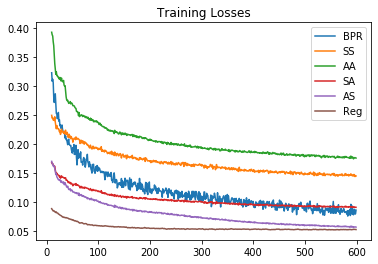

In [20]:
training_losses_arr = np.array(training_losses)[:,:6]
plt.plot(range(10,len(training_losses)),training_losses_arr[10:,0],label = 'BPR')
plt.plot(range(10,len(training_losses)),training_losses_arr[10:,1],label = 'SS')
plt.plot(range(10,len(training_losses)),training_losses_arr[10:,2],label = 'AA')
plt.plot(range(10,len(training_losses)),training_losses_arr[10:,3],label = 'SA')
plt.plot(range(10,len(training_losses)),training_losses_arr[10:,4],label = 'AS')
plt.plot(range(10,len(training_losses)),training_losses_arr[10:,5],label = 'Reg')
plt.title('Training Losses')
plt.legend()
plt.show()

## Extracting the embeddings
We now extract the embeddings learned in the trained model, normalize them, and save them to disk for use in future models, along with the original unnormalized embeddings. We save the $\bar{e}$ vectors, which were used to train the matrix factorisation co-occurrence losses, as well as the model parameters themselves.

In [21]:
user_embeds = tl_mgccf.embeddings['user'].numpy()
song_embeds = tl_mgccf.embeddings['song'].numpy()
artist_embeds = tl_mgccf.embeddings['artist'].numpy()

In [22]:
gcn_output_user = tl_mgccf.call_gcn([tl_mgccf.embeddings['user'],
                                     user_graph_normalized],'user').numpy()
gcn_output_song = tl_mgccf.call_gcn([tl_mgccf.embeddings['song'],
                                     graph_normalized],'song').numpy()
gcn_output_artist = tl_mgccf.call_gcn([tl_mgccf.embeddings['artist'],
                                       artist_graph_normalized],'artist').numpy()

gcn_song_df_unnormalized = pd.DataFrame(gcn_output_song,index=song_lst)
gcn_artist_df_unnormalized = pd.DataFrame(gcn_output_artist,index=artist_lst)
gcn_user_df_unnormalized = pd.DataFrame(gcn_output_user,index=user_lst)

In [23]:
gcn_output_song_normalized = gcn_output_song/np.linalg.norm(gcn_output_song, 
                                                            ord=2, axis=1, 
                                                            keepdims=True)
gcn_output_artist_normalized = gcn_output_artist/np.linalg.norm(gcn_output_artist, 
                                                                ord=2, axis=1, 
                                                                keepdims=True)
gcn_output_user_normalized = gcn_output_user/np.linalg.norm(gcn_output_user, 
                                                            ord=2, axis=1, 
                                                            keepdims=True)

gcn_song_df = pd.DataFrame(gcn_output_song_normalized,index=song_lst)
gcn_artist_df = pd.DataFrame(gcn_output_artist_normalized,index=artist_lst)
gcn_user_df = pd.DataFrame(gcn_output_user_normalized,index=user_lst)

In [24]:
gcn_song_df_unnormalized.to_csv('gcn_song_embeddings_2021_unnormalized.csv')
gcn_artist_df_unnormalized.to_csv('gcn_artist_embeddings_2021_unnormalized.csv')
gcn_user_df_unnormalized.to_csv('gcn_user_embeddings_2021_unnormalized.csv')

gcn_song_df.to_csv('gcn_song_embeddings_2021.csv')
gcn_artist_df.to_csv('gcn_artist_embeddings_2021.csv')
gcn_user_df.to_csv('gcn_user_embeddings_2021.csv')

tl_mgccf_weights_lst = tl_mgccf.get_weights()
with open('user_recommendation_2021/tl_mgccf_weights_expanded_lst.pkl','wb') as f:
    pickle.dump(tl_mgccf_weights_lst,f)
    
tl_mgccf_weights = {}
for x in tl_mgccf.variables:
    tl_mgccf_weights[x.name.split('/')[-1].split(':')[0]] = x.numpy()

with open('user_recommendation_2021/tl_mgccf_weights_expanded.pkl','wb') as f:
    pickle.dump(tl_mgccf_weights,f)

## Evaluating the model
We now take a brief look at the recommendations the TL-MGCCF model can now make. To see these recommendations for any track or DJ in the database, visit the [Tracklist AI website](https://tracklist-ai.azurewebsites.net/).
### Song and Artist Embeddings
To create a final embedding for each song, we add together the GCN output vectors for the song and its mapped artists. To get recommendations, we then take cosine similarity and take a look at nearest neighbours for a few example songs.

In [25]:
gcn_song_artist = gcn_output_song + song_artist_map_sparse @ gcn_output_artist
song_sim_final = pd.DataFrame(cosine_similarity(gcn_song_artist,gcn_song_artist),
                              index=song_lst,columns=song_lst)

In [26]:
song_sim_final.loc["FISHER - Losing It"].sort_values(ascending=False).iloc[:20]

FISHER - Losing It                                                                   1.000000
FISHER - Ya Didn't                                                                   0.926355
FISHER - Stop It                                                                     0.922130
FISHER - You Little Beauty                                                           0.921207
FISHER - Crowd Control                                                               0.914563
FISHER - Ya Kidding                                                                  0.912503
Chris Lake & Marco Lys - La Tromba                                                   0.884324
Snoop Dogg ft. Pharrell - Drop It Like It's Hot (Del-30 Drop It Like A Gee Thang)    0.864790
Calvin Harris & Sam Smith - Promises (Sonny Fodera Remix)                            0.856416
FISHER - We FKN Love It                                                              0.856142
Kelis X Freejak - My Milkshake (Leftwing : Kody Remix)      

In [27]:
song_sim_final.loc["CID & Westend - Jumpin'"].sort_values(ascending=False).iloc[:20]

CID & Westend - Jumpin'                                          1.000000
Biscits - Talk To Me                                             0.937240
Miane - Who Are You? (Chris Lake Remix)                          0.934783
John Summit - Make Me Feel                                       0.925049
Gorgon City & DRAMÄ - You've Done Enough (John Summit Remix)    0.924890
Dom Dolla - Pump The Brakes                                      0.922821
CID ft. Lizzy Land - Can't Stop Missing You                      0.922164
Jaded & Indira May - The Lights                                  0.921636
CID ft. Gramercy - Bruises                                       0.902126
SIDEPIECE - Temptation                                           0.897998
GUZ - Set U Free                                                 0.897722
John Summit - Beauty Sleep                                       0.896418
Martin Ikin & Biscits ft. Anelisa Lamola - Ready 2 Dance         0.892894
Sonickraft & Vanilla Ace - Dangerous  

In [28]:
song_sim_final.loc["Endor - Pump It Up"].sort_values(ascending=False).iloc[:20]

Endor - Pump It Up                                              1.000000
Dom Dolla - San Frandisco                                       0.918604
Marshall Jefferson & Solardo - Move Your Body                   0.913790
Duke Dumont ft. Zak Abel - The Power (Leftwing : Kody Remix)    0.910521
Martin Ikin - Hooked                                            0.902478
Joel Corry - The Parade                                         0.897188
OFFAIAH & BACATME - What I Grew Up On                           0.897082
Duke Dumont ft. Zak Abel - The Power                            0.896859
Endor - Phonesex                                                0.893543
MK & Sonny Fodera ft. Raphaella - One Night                     0.888452
Piero Pirupa - Braindead                                        0.882855
Martin Ikin ft. Dope Earth Alien - Headnoise (Get Hype)         0.882645
Joel Corry - Sorry                                              0.881808
Roberto Surace - Joys                              

### User recommendations
We can get a recommendation score for each song for each user by running the TL-MGCCF model once. However, due to the neighbourhood sampling process, a single run will not be fully representative. We therefore run the model many times to get an average score for each user-song pair across a variety of samples. This is useful if we want a fixed score; if we want more stochastic behaviour, then a single run of the model is more suitable.

In [30]:
user_vecs_out = np.zeros((1275,64))
song_artist_concat_vecs_out = np.zeros((31214,64))

num_repeats = 250
print('running')
for j in range(num_repeats):
    h_u_0_s,h_s_0 = tl_mgccf.mgccf_bipar_gcn(tl_mgccf.embeddings['user'],
                                             tl_mgccf.embeddings['song'],1,'s',
                                             tl_mgccf.user_song_adjacency_scaled_user,
                                             tl_mgccf.user_song_adjacency_scaled_song)

    h_u_0_a,h_a_0 = tl_mgccf.mgccf_bipar_gcn(tl_mgccf.embeddings['user'],
                                             tl_mgccf.embeddings['artist'],1,'a',
                                             tl_mgccf.user_artist_adjacency_scaled_user,
                                             tl_mgccf.user_artist_adjacency_scaled_artist)


    h_u_1_s,h_s_1 = tl_mgccf.mgccf_bipar_gcn(h_u_0_s,h_s_0,2,'s',
                                             tl_mgccf.user_song_adjacency_scaled_user,
                                             tl_mgccf.user_song_adjacency_scaled_song)

    h_u_1_a,h_a_1 = tl_mgccf.mgccf_bipar_gcn(h_u_0_a,h_a_0,2,'a',
                                             tl_mgccf.user_artist_adjacency_scaled_user,
                                             tl_mgccf.user_artist_adjacency_scaled_artist)

    user_vecs_final_s = h_u_1_s.numpy() + gcn_output_user
    user_vecs_final_a = h_u_1_a.numpy() + gcn_output_user
    song_vecs_final = h_s_1.numpy() + gcn_output_song
    artist_vecs_final = h_a_1.numpy() + gcn_output_artist

    user_vecs_final = np.concatenate([user_vecs_final_s,user_vecs_final_a],axis=-1)
    song_artist_concat_vecs = np.concatenate([song_vecs_final,
                                              song_artist_map_sparse @ artist_vecs_final],
                                             axis=-1)
    
    user_vecs_out += user_vecs_final
    song_artist_concat_vecs_out += song_artist_concat_vecs
    if (j+1)%100==0:
        print(j+1)
user_vecs_out /= num_repeats
song_artist_concat_vecs_out /= num_repeats

running
100
200


To get a final recommendation score, we can take the cosine similarity of the resulting user vectors with the resulting song/artist vectors, and again look at a few examples of the top recommendations for various users.

In [31]:
sim = pd.DataFrame(cosine_similarity(user_vecs_out,song_artist_concat_vecs_out),
                   index=user_lst,columns=song_lst)

In [32]:
sim.loc['FISHER',:].sort_values(ascending=False).iloc[:20]

Fatboy Slim - Praise You                                                           0.785277
Peggy Gou - Starry Night                                                           0.774737
Marie Davidson - Work It (Soulwax Remix)                                           0.755314
DJ Deeon vs. Lee Walker ft. Katy B & MNEK - Freak Like Me                          0.753532
Childish Gambino - This Is America (Todd Terry & Kenny Dope & Louie Vega Remix)    0.743742
Idris Elba - Badman                                                                0.743034
Melé ft. Lazarusman - The Panther                                                 0.739152
Hannah Wants - You Keep Comin'                                                     0.738786
Julien Jabre - Swimming Places (Purple Disco Machine Rework)                       0.731813
Purple Disco Machine - Body Funk                                                   0.731162
Purple Disco Machine - Emotion                                                  

In [33]:
sim.loc['Diplo',:].sort_values(ascending=False).iloc[:20]

Diplo & Wax Motif - Love To The World                                            0.823436
Kito & ZHU & Jeremih - Follow (Dillon Francis Remix)                             0.787789
Cardi B - Money Bag (Lazy Flow Afro Funk Edit)                                   0.784853
Phantoms - One In A Million                                                      0.780310
Dillon Francis ft. BabyJake - Touch (Jaded Remix)                                0.772727
Phantoms ft. Sarah Close - Moonlight                                             0.767247
Snoop Dogg ft. Pharrell - Drop It Like It's Hot                                  0.760939
LSD - No New Friends (Dombresky Remix)                                           0.759904
Hermitude ft. BJ The Chicago Kid & Buddy - OneFourThree (Friend Within Remix)    0.750606
Dombresky - Housology                                                            0.747602
Dillon Francis ft. BabyJake - You Do You                                         0.747280
Megan Thee

In [34]:
sim.loc['Tchami',:].sort_values(ascending=False).iloc[:20]

Dombresky - Utopia                                                             0.819524
BELLECOUR - He Was Like                                                        0.805124
Bart B More - Rave Lab                                                         0.795330
Wax Motif ft. Diddy - Divided Souls                                            0.790695
Tchami - Siaw                                                                  0.789926
Brodinski ft. Louisahhh!!! - Let The Beat Control Your Body (BELLECOUR VIP)    0.788345
Dombresky & Tony Romera - Girls Night Out                                      0.784953
AC Slater & Chris Lorenzo - Fly Kicks (Wax Motif Remix)                        0.780202
Dombresky - Utopia (Madeaux Remix)                                             0.775279
Born Dirty - Squeaky                                                           0.774056
Tony Romera - Oldskool                                                         0.772830
Tchami & Malaa - Kurupt         

#### Validation Set Performance
We can also assess performance on our validation set. We will do this with the precision@k and recall@k metrics commonly used for evaluating recommender systems. Given a user $u$ with a set of relevant items $I$, a precision@k score of 0.5 indicates that 50% of the top k recommendations for that user are in $I$; a recall@k score of 0.5 indicates that 50% of the members of $I$ appear in the top k recommendations. We will examine the precision@k scores for the training set and compare the recall@k metric across the training set and validation set for several values of k. 

First, we load in the validation set:

In [36]:
with open('user_song_vad_inds.pkl','rb') as f:
    x_inds_vad,y_inds_vad = pickle.load(f)

unique_vad_users = list(set(x_inds_vad))

We now define the function for calculating the precision@k and the recall@k. This function is adapted from the [implementation](https://github.com/dawenl/vae_cf/blob/master/VAE_ML20M_WWW2018.ipynb) of Liang et al.'s [Variational Autoencoders For Collaborative Filtering](https://arxiv.org/abs/1802.05814).

In [37]:
def Precision_Recall_at_k_batch(X_pred, heldout_batch, k=100):
    """Function for calculating precision@k recall@k in a recommender system.
    
        Args:
            X_pred: Recommendation scores in a sparse matrix with shape 
                (n_users,n_items).
            heldout_batch: A (n_users,n_items) matrix with ones at the 
                locations of the validation examples and zeros elsewhere.
            k: k-value which represents the number of items to consider.
        Returns:
            average precision@k and recall@k across the batch
    
    """
    batch_users = X_pred.shape[0]

    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(
        np.float32)
    precision = tmp / k
    recall = tmp / np.minimum(k, X_true_binary.sum(axis=1))
    return [np.mean(precision),np.mean(recall)]

We build the indicator arrays which contain the positive examples for both the training and validation set, and convert these to sparse matrices.

In [38]:
train_examples_arr = np.zeros_like(sim)
for j in range(len(x_inds_train)):
    train_examples_arr[x_inds_train[j],y_inds_train[j]] = 1

train_examples_sparse = csr_matrix(train_examples_arr)

vad_examples_arr = np.zeros_like(sim)
for j in range(len(x_inds_vad)):
    vad_examples_arr[x_inds_vad[j],y_inds_vad[j]] = 1

vad_examples_sparse = csr_matrix(vad_examples_arr[unique_vad_users])


We can now calculate the precision@k on the training set and the recall@k across both datasets for a variety of values of k, using the similarity matrix calculated above for the recommender ranking:

In [39]:
k_values = [10,25,50,100,300,500]
training_metrics = [Precision_Recall_at_k_batch(sim,
                                              train_examples_sparse,k=k) for k in k_values]

training_precisions = [x[0] for x in training_metrics]
training_recalls = [x[1] for x in training_metrics]
vad_recalls = [Precision_Recall_at_k_batch(sim.values[unique_vad_users],
                                         vad_examples_sparse,k=k)[1] for k in k_values]

k_df = pd.DataFrame([training_precisions,training_recalls,vad_recalls],
                    index=['Training Precision@k','Training Recall@k','Validation Recall@k'],
            columns = k_values).T
k_df.index.name = 'k'
print(tabulate(k_df,headers='keys',numalign="center"))

 k    Training Precision@k    Training Recall@k    Validation Recall@k
---  ----------------------  -------------------  ---------------------
10          0.305569              0.305569              0.0108634
25          0.267639              0.276529              0.0295117
50          0.232471              0.288531              0.0696947
100         0.194588              0.340044              0.131625
300         0.134052              0.516485              0.274678
500         0.106089              0.624709              0.371856


Unsurprisingly, the recall@k on the training set is significantly higher than on the validation set. Not only is the model trained directly on those examples, but those examples are also part of the click matrices which are sampled in the Bipar-GCN steps of MGCCF. However, it is clear that the model is not just memorising those examples, as shown by the precision@k on the training set, since the majority of the top k are not part of the positive examples in the training set; the model strikes a balance between recommending new items and familiar items. Furthermore, the recall@k on the validation set indicates that the model's new recommendations are valuable, successfully capturing over 27% of the holdout set in the top 300 recommendations, i.e. in 1% of the total population.